## Import packages

In [69]:
import boto3
import pandas as pd
import geojson as gsn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import spatial analysis packages
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point
import geoplot.crs as gcrs
import geoplot as gplt
import pyproj
from shapely.geometry import Polygon


## Load data in

### Ground Measures Data

In [103]:
gm_md = pd.read_csv("../data/ground_measures_metadata.csv")
gm_md = gpd.GeoDataFrame(gm_md, geometry=gpd.points_from_xy(gm_md.longitude, gm_md.latitude))
gm_md

,station_id,name,elevation_m,latitude,longitude,state,geometry
0,CDEC:ADM,Adin Mountain,1889.760000,41.237000,-120.792000,California,POINT (-120.79200 41.23700)
1,CDEC:AGP,Agnew Pass,2880.360000,37.726631,-119.141731,California,POINT (-119.14173 37.72663)
2,CDEC:ALP,Alpha (Smud),2316.480000,38.804192,-120.215652,California,POINT (-120.21565 38.80419)
3,CDEC:BCB,Blackcap Basin,3139.440000,37.066685,-118.773010,California,POINT (-118.77301 37.06668)
4,CDEC:BCH,Beach Meadows,2331.720000,36.126095,-118.293457,California,POINT (-118.29346 36.12609)
...,...,...,...,...,...,...,...
759,SNOTEL:994_WA_SNTL,Epa Quinault Open,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
760,SNOTEL:995_WA_SNTL,Epa Quinault Can,91.440002,46.483330,-123.966667,Washington,POINT (-123.96667 46.48333)
761,SNOTEL:996_WA_SNTL,NWA Heather Mdws,1267.968018,48.849998,-121.666672,Washington,POINT (-121.66667 48.85000)
762,SNOTEL:998_WA_SNTL,Easy Pass,1606.296021,48.859329,-121.438950,Washington,POINT (-121.43895 48.85933)


### Cell grids

In [27]:
path = "../data/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))
# gj['features']

18130


In [53]:
gj.keys()

dict_keys(['type', 'crs', 'features'])

In [54]:
gj['features'][1]

{"geometry": {"coordinates": [[[-107.076787, 37.780424], [-107.076787, 37.787523], [-107.08577, 37.787523], [-107.08577, 37.780424], [-107.076787, 37.780424]]], "type": "Polygon"}, "properties": {"cell_id": "000617d8-8c14-43e2-b708-7e3a69fe3cc3", "region": "central rockies"}, "type": "Feature"}

Let's transform our geojson data into a dataframe so its easier to look at and work with

In [57]:
grid_cell_df = pd.DataFrame.from_dict(gj['features'])
grid_cell_df['cell_id'] = [x['cell_id'] for x in grid_cell_df['properties']]
grid_cell_df['poly'] = [x['coordinates'][0][0:] for x in grid_cell_df['geometry']]
grid_cell_df['region'] = [x['region'] for x in grid_cell_df['properties']]
grid_cell_df = grid_cell_df.drop(['type','geometry','properties'],axis=1)
grid_cell_df

,cell_id,poly,region
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,"[[-118.718953, 37.074192], [-118.718953, 37.08...",sierras
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,"[[-107.076787, 37.780424], [-107.076787, 37.78...",central rockies
2,000863e7-21e6-477d-b799-f5675c348627,"[[-119.401673, 37.024005], [-119.401673, 37.03...",other
3,000ba8d9-d6d5-48da-84a2-1fa54951fae1,"[[-119.320824, 37.431707], [-119.320824, 37.43...",sierras
4,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,"[[-118.521324, 36.657353], [-118.521324, 36.66...",sierras
...,...,...,...
18125,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,"[[-118.620138, 37.117184], [-118.620138, 37.12...",sierras
18126,ffe43514-2c92-43b6-bd84-d183806aca65,"[[-123.49799, 47.901318], [-123.49799, 47.9073...",other
18127,ffeabc13-7c6f-4b63-b043-19c8f15e0345,"[[-119.644218, 37.879756], [-119.644218, 37.88...",sierras
18128,fff95195-ccc9-40b7-b302-a0d8570c86bc,"[[-123.372226, 47.732416], [-123.372226, 47.73...",other


#### Visualizing location of our cell grids.

Let's visualize the locations of our data so we know where in the map we are working in and if there's any unsual locations hidden in our data.

In [91]:
#transform grid cell data to geopandas df

geometry = [Polygon(eval(str(xy_string))) for xy_string in grid_cell_df['poly']]
grid_cell_df = gpd.GeoDataFrame(grid_cell_df,geometry=geometry)

In [76]:
grid_cell_df.geometry

0        POLYGON ((-118.71895 37.07419, -118.71895 37.0...
1        POLYGON ((-107.07679 37.78042, -107.07679 37.7...
2        POLYGON ((-119.40167 37.02401, -119.40167 37.0...
3        POLYGON ((-119.32082 37.43171, -119.32082 37.4...
4        POLYGON ((-118.52132 36.65735, -118.52132 36.6...
                               ...                        
18125    POLYGON ((-118.62014 37.11718, -118.62014 37.1...
18126    POLYGON ((-123.49799 47.90132, -123.49799 47.9...
18127    POLYGON ((-119.64422 37.87976, -119.64422 37.8...
18128    POLYGON ((-123.37223 47.73242, -123.37223 47.7...
18129    POLYGON ((-123.79443 47.52052, -123.79443 47.5...
Name: geometry, Length: 18130, dtype: geometry

In [89]:
grid_cell_df.geometry.crs

<AxesSubplot:>

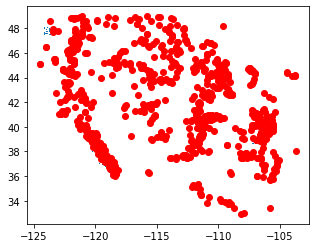

In [105]:
ax = grid_cell_df.plot()
gm_md.plot(ax=ax,c='r')

### Training data

Below is the 

In [15]:
gm_train_feat = pd.read_csv("../data/ground_measures_train_features.csv")
gm_train_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_train_feat

,station_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-05-28,2019-06-04,2019-06-11,2019-06-18,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31
0,CDEC:ADM,5.90,5.90,6.50,6.50,7.40,7.60,7.40,8.00,8.00,...,NaN,NaN,NaN,NaN,NaN,0.70,1.20,3.40,3.70,3.40
1,CDEC:AGP,17.52,17.54,17.85,17.39,18.03,17.70,17.65,16.66,17.21,...,NaN,NaN,NaN,NaN,NaN,0.00,0.60,0.20,NaN,NaN
2,CDEC:ALP,12.75,13.32,14.26,14.02,13.39,13.25,14.30,13.95,15.73,...,29.52,20.81,8.71,0.30,0.00,5.69,8.04,10.74,12.67,12.57
3,CDEC:BCB,4.30,4.42,4.62,4.53,4.67,4.90,4.90,5.06,5.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CDEC:BCH,2.88,3.00,3.48,3.84,3.96,4.44,5.40,5.16,3.60,...,0.84,0.60,0.36,0.36,0.24,2.88,4.56,4.68,5.04,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,9.00,10.20,10.90,11.10,12.80,14.10,14.40,14.60,17.60,...,0.00,0.00,0.00,0.00,0.00,0.30,0.20,1.60,2.80,3.00
696,SNOTEL:990_WA_SNTL,27.50,29.10,31.50,31.90,33.40,33.90,35.40,36.50,38.80,...,6.00,0.10,0.00,0.00,0.00,1.00,0.90,2.30,8.70,8.60
697,SNOTEL:992_UT_SNTL,4.10,4.10,4.40,4.50,4.80,5.10,5.20,5.30,6.10,...,0.00,0.00,0.00,0.00,0.00,2.00,2.20,3.50,3.60,3.80
698,SNOTEL:998_WA_SNTL,48.40,55.50,61.50,62.20,67.50,70.10,72.90,77.00,83.30,...,53.60,36.10,31.30,8.50,0.00,8.00,9.00,13.20,23.70,25.00


In [13]:
train_labels = pd.read_csv("../data/train_labels.csv")
labels

,cell_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,000863e7-21e6-477d-b799-f5675c348627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000ba8d9-d6d5-48da-84a2-1fa54951fae1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00211c19-7ea8-4f21-a2de-1d6216186a96,NaN,NaN,NaN,NaN,NaN,4.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00226e82-e747-4f03-9c5d-3eef8ebe515e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.3,NaN,NaN,NaN,NaN,NaN,NaN
9062,ffce8731-d78f-4c06-ace2-7029b611f1ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9063,ffd1aa25-27a5-4b28-abb6-e6577d1575be,NaN,NaN,NaN,NaN,NaN,11.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9064,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df = pd.read_csv("../data/train_labels.csv")
df.melt(id_vars=["cell_id"]).dropna()

,cell_id,variable,value
43,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7
77,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4
85,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0
120,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3
121,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0
...,...,...,...
2904295,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3
2904321,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6
2904323,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8
2904336,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9


### Testing Data

The dataset below is the ground truth data for our testing data. This will be reserved to test our model performance on unseen data.

In [16]:
gm_test_feat = pd.read_csv("../data/ground_measures_test_features.csv")
gm_test_feat.rename(columns={'Unnamed: 0': "station_id"},inplace=True)
gm_test_feat

,station_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,CDEC:ADM,4.50,5.50,7.30,8.30,8.10,8.20,9.30,8.50,7.90,...,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDEC:AGP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CDEC:ALP,12.72,13.78,17.12,18.07,18.17,18.38,17.71,16.05,14.62,...,3.34,0.31,0.02,0.00,0.13,0.01,0.00,0.00,0.00,0.00
3,CDEC:BCB,12.20,12.20,13.30,13.35,12.85,12.72,12.72,12.80,13.16,...,15.44,11.94,5.91,1.10,0.86,1.04,1.12,1.04,1.17,1.25
4,CDEC:BCH,6.60,5.76,5.16,7.68,4.68,1.32,0.84,0.84,0.24,...,0.12,0.24,0.24,0.24,0.12,0.24,0.12,0.24,0.24,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,SNOTEL:989_ID_SNTL,6.80,12.50,13.10,14.40,16.30,19.10,19.80,19.80,19.70,...,6.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
696,SNOTEL:990_WA_SNTL,13.80,17.00,20.30,24.90,26.70,29.40,29.80,31.10,32.60,...,41.20,38.10,35.90,32.10,28.50,23.20,16.70,10.60,0.90,0.00
697,SNOTEL:992_UT_SNTL,4.40,5.00,5.80,6.20,6.30,6.80,7.20,7.40,7.80,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
698,SNOTEL:998_WA_SNTL,37.90,47.00,51.80,61.90,69.00,73.40,77.30,81.40,83.60,...,96.00,95.10,95.50,94.20,94.20,NaN,75.10,70.40,58.70,35.10


In [18]:
test_labels = pd.read_csv("../data/submission_format.csv")
test_labels

,cell_id,2020-01-07,2020-01-14,2020-01-21,2020-01-28,2020-02-04,2020-02-11,2020-02-18,2020-02-25,2020-03-03,...,2021-04-27,2021-05-04,2021-05-11,2021-05-18,2021-05-25,2021-06-01,2021-06-08,2021-06-15,2021-06-22,2021-06-29
0,000863e7-21e6-477d-b799-f5675c348627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000ba8d9-d6d5-48da-84a2-1fa54951fae1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00146204-d4e9-4cd8-8f86-d1ef133c5b6d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00211c19-7ea8-4f21-a2de-1d6216186a96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00226e82-e747-4f03-9c5d-3eef8ebe515e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9061,ffcc02b0-5185-4f6a-bdfd-1ae1b6c68e99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9062,ffce8731-d78f-4c06-ace2-7029b611f1ba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9063,ffd1aa25-27a5-4b28-abb6-e6577d1575be,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9064,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
test_labels.shape[0]

9066

## MODIS data

### Helper Functions

These helper functions are from a notebook example provided by [DrivenData](https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/) [here](https://nbviewer.org/github/microsoft/AIforEarthDataSets/blob/main/data/modis.ipynb).

In [101]:
import tempfile
import wget
import numpy as np
import matplotlib.pyplot as plt
import os

from azure.storage.blob import ContainerClient

ModuleNotFoundError: No module named 'azure'

In [98]:
def lat_lon_to_modis_tile(lat,lon):
    """
    Get the modis tile indices (h,v) for a given lat/lon
    
    https://www.earthdatascience.org/tutorials/convert-modis-tile-to-lat-lon/
    """
    
    found_matching_tile = False
    i = 0
    while(not found_matching_tile):
        found_matching_tile = lat >= modis_tile_extents[i, 4] \
        and lat <= modis_tile_extents[i, 5] \
        and lon >= modis_tile_extents[i, 2] and lon <= modis_tile_extents[i, 3]
        i += 1
        
    v = int(modis_tile_extents[i-1, 0])
    h = int(modis_tile_extents[i-1, 1])
    
    return h,v


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files   